# Identification rate metric
IR metric for two models:
- resnet50 with CE loss
- resnet18 with ArcFace loss

In [30]:
import numpy as np
from torch.autograd import Variable
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data_utils
import torch
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm, tqdm_notebook
from IPython.display import clear_output
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
from torch.optim import lr_scheduler
from PIL import Image
import random

import os
import pandas as pd
import skimage.io
from skimage.transform import resize


%matplotlib inline

In [2]:
RESCALE_SIZE = 100

# dataset
данные лиц 500 людей CelebA-500. Они уже выровнены. Скачать можно тут: https://disk.yandex.ru/d/S8f03spLIA1wrw  
    Внутри:  
        - celebA_imgs — папка с выровненными картинками;  
        - celebA_anno.txt — файл с аннотацией — каждой картинке из celebA_imgs поставлен в соответствие ее id;  
        - celebA_train_split.txt — файл со сплитом на train/val/test.  
    Эти данные — часть открытого датасета [CelebA](https://colab.research.google.com/corgiredirector?site=https%3A%2F%2Fmmlab.ie.cuhk.edu.hk%2Fprojects%2FCelebA.html), который один из стандартных для обучения моделей, связанных с лицами.  

In [3]:
#read attrs
df_attrs = pd.read_csv("./data/celebA_train_500/celebA_anno.txt", header=None, sep=' ')
df_attrs.columns = ['name_img', 'id']
df_attrs.head()

name_img  id
0  000001.jpg   0
1  000404.jpg   0
2  003415.jpg   0
3  004390.jpg   0
4  018062.jpg   0

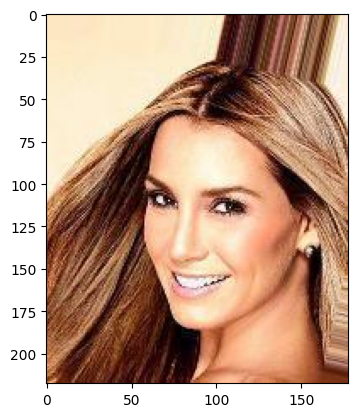

In [4]:
img = skimage.io.imread("./data/celebA_train_500/celebA_imgs/000001.jpg")
plt.imshow(img);

In [5]:
#train val test split
split = pd.read_csv("./data/celebA_train_500/celebA_train_split.txt", header=None, sep=' ')
split.columns = ['name_img', 'class']
split.head()

name_img  class
0  000001.jpg      0
1  000404.jpg      0
2  003415.jpg      0
3  004390.jpg      0
4  018062.jpg      0

In [6]:
class CustomDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, path, files, labels, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = files
        self.labels = labels
        # режим работы
        self.mode = mode
        self.path = path

        self.len_ = len(self.files)


    def __len__(self):
        return self.len_

    def load_sample(self, file):
        if self.mode != 'metric':
            image = np.array(Image.open(f'{self.path}/{file}'))
            image = Image.fromarray(image[77:-41,45:-50])
        else:
            image = Image.open(f'{self.path}/{file}')
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            # transforms.RandomRotation(degrees=30),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        aug = transforms.Compose([
            transforms.ColorJitter(),
            transforms.RandomHorizontalFlip()
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)       
        #x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'train':
            x = aug(x)

        if self.labels: 
            label = self.labels[self.files[index]]
        else:
            label = 0
        return x, label

    def _prepare_sample(self, image):
#         padding = transforms.Pad(padding=((RESCALE_SIZE - image.size[1]) // 2, (RESCALE_SIZE - image.size[0]) // 2))
#         image = padding(image)
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [7]:
train_files = list(split[split['class'] == 0]['name_img'])
val_files = list(split[split['class'] == 1]['name_img'])
test_files = list(split[split['class'] == 2]['name_img'])

In [8]:
labels = dict(zip(df_attrs['name_img'], df_attrs['id']))

In [9]:
# read images
img_path = './data/celebA_train_500/celebA_imgs'
train_dataset = CustomDataset(img_path, train_files, labels, mode='train')
val_dataset = CustomDataset(img_path, val_files, labels, mode='val')
test_dataset = CustomDataset(img_path, test_files, labels, mode='test')

In [10]:
batch_size=32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# model_CE

In [121]:
# Set the seed for PyTorch
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [122]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [123]:
model = torch.load('./models/model_ce.bin', map_location=torch.device('cpu'))

In [124]:
model.eval()
test_correct = 0
test_total_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)
        test_correct += (test_predicted == test_labels).sum().item()
        test_total_samples += test_labels.size(0)

test_accuracy = test_correct / test_total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7369


# IR metric

При обучении модели для распознавания лиц с помощью CE (кросс-энтропии) мы можем считать метрику accuracy как индикатор того, насколько хорошо наша модель работает. Но у accuracy тут есть недостаток: она не сможет померить, насколько хорошо наша модель работает на лицах людей, которых нет в обучающей выборке.  

Чтобы это исправить, придумали новую метрику: **identification rate**. Вот как она работает:

Создадим два набора изображений лиц: query и distractors. Никакие лица из этих наборов не должны содержаться в обучающем и валидационном датасете.

1. посчитаем косинусные расстояния между лицами, соответствующими одним и тем же людям из query части. Например, пусть одному человеку соответствуют три фото в query: 01.jpg, 02.jpg, 03.jpg. Тогда считаем три косинусных расстояния между всеми тремя парами из этих фото.
2. посчитаем косинусные расстояния между лицами, соответствующими разным людям из query части.
3. посчитаем косинусные расстояния между всеми парами лиц из query и distractors. Т.е. пара — это (лицо из query, лицо из distractors). Всего получится |query|*|distractors| пар.
4. Сложим количества пар, полученных на 2 и 3 шагах. Это количество false пар.
5. Зафиксируем **FPR** (false positive rate). Пусть, например, будет 0.01. FPR, умноженный на количество false пар из шага 4 — это разрешенное количество false positives, которые мы разрешаем нашей модели. Обозначим это количество через N.
6. Отсортируем все значения косинусных расстояний false пар. N — ое по счету значение расстояния зафиксируем как **пороговое расстояние**.
7. Посчитаем количество positive пар с шага 1, которые имеют косинусное расстояние меньше, чем пороговое расстояние. Поделим это количество на общее количество positive пар с шага 1. Это будет TPR (true positive rate) — итоговое значение нашей метрики.

Такая метрика обычно обозначается как TPR@FPR=0.01. FPR может быть разным. Приразных FPR будет получаться разное TPR.

Смысл этой метрики в том, что мы фиксируем вероятность ошибки вида false positive, т.е. когда "сеть сказала, что это один и тот же человек, но это не так", считаем порог косинусного расстояния для этого значения ошибки, потом берем все positive пары и смотрим, у скольких из них расстояние меньше этого порога. Т.е. насколько точно наша сеть ищет похожие лица при заданной вероятности ошибки вида false positive.

**Данные**. Если вы обучали нейросеть для распознавания лиц на данных, предложенных в этом ноутбуке (CelebA-500), то для подсчета метрики вы можете воспользоваться данными, которые лежат по этой ссылке: https://disk.yandex.com/d/KN4EEkNKrF_ZXQ. Эти данные уже разбиты на query и distractors, и в отдельном файле также находится информация о классах для картинок из query. Эти картинки заалайнены точно так же, как картинки из обучающей выборки CelebA-500

Если вы обучали нейросеть на других данных, то вам нужно сделать данные для тестирования самому. Делается это примерно так:
- Выбраете несколько id, которые не использовались при тренировке моделей, и помещаете их в query set;
- Выбираете несколько id, которые не использовались при тренировке моделей и не входят в query, и помещаете их в distractors set. Обычно distractors set должен быть сильно больше, чем query set.
- Обрабатываете картинки из query и distractors тем же способом, что картинки для обучения сети.


Обратите внимание, что если картинок в query и distractors очень много, то полученных пар картинок в пунктах 1-2-3 алгоритма подсчета TPR@FPR будет очень-очень много. Чтобы код подсчета работал быстрее, ограничивайте размеры этих датасетов. Контролируйте, сколько значений расстояний вы считаете.

Ниже дан шаблон кода для реализации FPR@TPR метрики и ячейки с тестами. Тесты проверяют, что ваш код в ячейках написан правильно.

In [15]:
from collections import defaultdict

# file with query part annotations: which image belongs to which class
# format:
#     image_name_1.jpg 2678
#     image_name_2.jpg 2679
f = open('./data/celebA_ir/celebA_anno_query.csv', 'r')
query_lines = f.readlines()[1:]
f.close()
query_lines = [x.strip().split(',') for x in query_lines]
# plain list of image names from query. Neede to compute embeddings for query
query_img_names = [x[0] for x in query_lines]

# dictionary with info of which images from query belong to which class
# format:
#     {class: [image_1, image_2, ...]}
query_dict = defaultdict(list)
for img_name, img_class in query_lines:
    query_dict[img_class].append(img_name)

# list of distractor images
distractors_img_names = os.listdir('./data/celebA_ir/celebA_distractors')

In [127]:
class ModelWithoutLastLayer(nn.Module):
    def __init__(self, model):
        super(ModelWithoutLastLayer, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        return self.features(x)
    
model_without_last_layer = ModelWithoutLastLayer(model)

In [17]:
def compute_embeddings(model, img_path, images_list):
    '''
      compute embeddings from the trained model for list of images.
      params:
        model: trained nn model that takes images and outputs embeddings
        images_list: list of images paths to compute embeddings for
      output:
        list: list of model embeddings. Each embedding corresponds to images
              names from images_list
    '''
    custom_dataset = CustomDataset(img_path, images_list, None, mode='metric')
    data_loader = DataLoader(custom_dataset, batch_size=32, shuffle=False)
    
    model.eval()
    embeddings = []
    with torch.no_grad():
        for inputs, _ in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs).detach().cpu().numpy()
            outputs = [list(i.flatten()) for i in outputs]            
            embeddings.extend(outputs)
       
    return embeddings

In [18]:
query_embeddings = compute_embeddings(model_without_last_layer, './data/celebA_ir/celebA_query', query_img_names)
distractors_embeddings = compute_embeddings(model_without_last_layer, './data/celebA_ir/celebA_distractors', distractors_img_names)

In [19]:
import math
import numpy as np

def cosine_similarity(v1,v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    return dot_product / (norm_v1 * norm_v2)

In [20]:
def compute_cosine_query_pos(query_dict, query_img_names, query_embeddings):
    '''
      compute cosine similarities between positive pairs from query (stage 1)
      params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                    the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
      output:
        list of floats: similarities between embeddings corresponding
                        to the same people from query list
    '''
    cos_sim = []
    for cl in query_dict:
        for i in range(len(query_dict[cl])):
            idx1 = query_img_names.index(query_dict[cl][i])
            obj1 = query_embeddings[idx1]
            for j in range(i+1,len(query_dict[cl])):
                idx2 = query_img_names.index(query_dict[cl][j])
                obj2 = query_embeddings[idx2]
                cs = cosine_similarity(obj1, obj2)
                cos_sim.append(cs)
    return cos_sim

def compute_cosine_query_neg(query_dict, query_img_names, query_embeddings):
    '''
      compute cosine similarities between negative pairs from query (stage 2)
      params:
        query_dict: dict {class: [image_name_1, image_name_2, ...]}. Key: class in
                    the dataset. Value: images corresponding to that class
        query_img_names: list of images names
        query_embeddings: list of embeddings corresponding to query_img_names
      output:
        list of floats: similarities between embeddings corresponding
                        to different people from query list
    '''
    cos_sim = []
    class_imgs = set()
    for cl in query_dict:
        class_imgs.update(query_dict[cl])
        for i in range(len(query_dict[cl])):
            idx1 = query_img_names.index(query_dict[cl][i])
            obj1 = query_embeddings[idx1]
            for j in range(len(query_img_names)):
                if query_img_names[j] not in class_imgs:
                    obj2 = query_embeddings[j]
                    cs = cosine_similarity(obj1, obj2)
                    cos_sim.append(cs)
    return cos_sim

def compute_cosine_query_distractors(query_embeddings, distractors_embeddings):
    '''
      compute cosine similarities between negative pairs from query and distractors
      (stage 3)
      params:
        query_embeddings: list of embeddings corresponding to query_img_names
        distractors_embeddings: list of embeddings corresponding to distractors_img_names
      output:
        list of floats: similarities between pairs of people (q, d), where q is
                        embedding corresponding to photo from query, d —
                        embedding corresponding to photo from distractors
    '''
    cos_sim = []
    for qe in query_embeddings:
        for de in distractors_embeddings:
            cs = cosine_similarity(qe, de)
            cos_sim.append(cs)
    return cos_sim

In [21]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

IOStream.flush timed out


Ячейка ниже проверяет, что код работает верно:

In [22]:
test_query_dict = {
    2876: ['1.jpg', '2.jpg', '3.jpg'],
    5674: ['5.jpg'],
    864:  ['9.jpg', '10.jpg'],
}
test_query_img_names = ['1.jpg', '2.jpg', '3.jpg', '5.jpg', '9.jpg', '10.jpg']
test_query_embeddings = [
                    [1.56, 6.45,  -7.68],
                    [-1.1 , 6.11,  -3.0],
                    [-0.06,-0.98,-1.29],
                    [8.56, 1.45,  1.11],
                    [0.7,  1.1,   -7.56],
                    [0.05, 0.9,   -2.56],
]

test_distractors_img_names = ['11.jpg', '12.jpg', '13.jpg', '14.jpg', '15.jpg']

test_distractors_embeddings = [
                    [0.12, -3.23, -5.55],
                    [-1,   -0.01, 1.22],
                    [0.06, -0.23, 1.34],
                    [-6.6, 1.45,  -1.45],
                    [0.89,  1.98, 1.45],
]

test_cosine_query_pos = compute_cosine_query_pos(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_neg = compute_cosine_query_neg(test_query_dict, test_query_img_names,
                                            test_query_embeddings)
test_cosine_query_distractors = compute_cosine_query_distractors(test_query_embeddings,
                                                            test_distractors_embeddings)

In [23]:
true_cosine_query_pos = [0.8678237233650096, 0.21226104378511604,
                         -0.18355866977496182, 0.9787437979250561]
assert np.allclose(sorted(test_cosine_query_pos), sorted(true_cosine_query_pos)), \
      "A mistake in compute_cosine_query_pos function"

true_cosine_query_neg = [0.15963231223161822, 0.8507997093616965, 0.9272761484302097,
                         -0.0643994061127092, 0.5412660901220571, 0.701307100338029,
                         -0.2372575528216902, 0.6941032794522218, 0.549425446066643,
                         -0.011982733001947084, -0.0466679194884999]
assert np.allclose(sorted(test_cosine_query_neg), sorted(true_cosine_query_neg)), \
      "A mistake in compute_cosine_query_neg function"

true_cosine_query_distractors = [0.3371426578637511, -0.6866465610863652, -0.8456563512871669,
                                 0.14530087113136106, 0.11410510307646118, -0.07265097629002357,
                                 -0.24097699660707042,-0.5851992679925766, 0.4295494455718534,
                                 0.37604478596058194, 0.9909483738948858, -0.5881093317868022,
                                 -0.6829712976642919, 0.07546364489032083, -0.9130970963915521,
                                 -0.17463101988684684, -0.5229363015558941, 0.1399896725311533,
                                 -0.9258034013399499, 0.5295114163723346, 0.7811585442749943,
                                 -0.8208760031249596, -0.9905139680301821, 0.14969764653247228,
                                 -0.40749654525418444, 0.648660814944824, -0.7432584300096284,
                                 -0.9839696492435877, 0.2498741082804709, -0.2661183373780491]
assert np.allclose(sorted(test_cosine_query_distractors), sorted(true_cosine_query_distractors)), \
      "A mistake in compute_cosine_query_distractors function"

И, наконец, финальная функция, которая считает IR metric:

In [24]:
def compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors,
               fpr=0.1):
    '''
      compute identification rate using precomputer cosine similarities between pairs
      at given fpr
      params:
        cosine_query_pos: cosine similarities between positive pairs from query
        cosine_query_neg: cosine similarities between negative pairs from query
        cosine_query_distractors: cosine similarities between negative pairs
                                  from query and distractors
        fpr: false positive rate at which to compute TPR
      output:
        float: threshold for given fpr
        float: TPR at given FPR
    '''
    num_false_pairs = len(cosine_query_neg) + len(cosine_query_distractors)
    good_amount_false_pos = round(fpr * num_false_pairs)
    all_false_pairs = []
    all_false_pairs.extend(cosine_query_neg)
    all_false_pairs.extend(cosine_query_distractors)
    all_false_pairs.sort(reverse=True)
    threshold = all_false_pairs[good_amount_false_pos]
    cnt = 0
    for i in cosine_query_pos:
        if i >= threshold:
            cnt += 1
    tpr = cnt / len(cosine_query_pos)
    return threshold, tpr

И ячейки для ее проверки:

In [25]:
test_thr = []
test_tpr = []
for fpr in [0.5, 0.3, 0.1]:
    x, y = compute_ir(test_cosine_query_pos, test_cosine_query_neg,
                    test_cosine_query_distractors, fpr=fpr)
    test_thr.append(x)
    test_tpr.append(y)

In [26]:
true_thr = [-0.011982733001947084, 0.3371426578637511, 0.701307100338029]
assert np.allclose(np.array(test_thr), np.array(true_thr)), "A mistake in computing threshold"

true_tpr = [0.75, 0.5, 0.5]
assert np.allclose(np.array(test_tpr), np.array(true_tpr)), "A mistake in computing tpr"

А в ячейке ниже вы можете посчитать TPR@FPR для датасета с лицами. Давайте, например, посчитаем для значений fpr = [0.5, 0.2, 0.1, 0.05].

In [27]:
fpr = [0.5, 0.2, 0.1, 0.05]
thresholds = []
ir = []
for f in fpr:
    thr, tpr = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=f)
    thresholds.append(thr)
    ir.append(tpr)

In [28]:
thresholds, ir

([0.5910196, 0.64237684, 0.6726222, 0.6986012],
 [0.9699748658379186,
  0.8546294409347192,
  0.7263093539841043,
  0.5961551525032267])

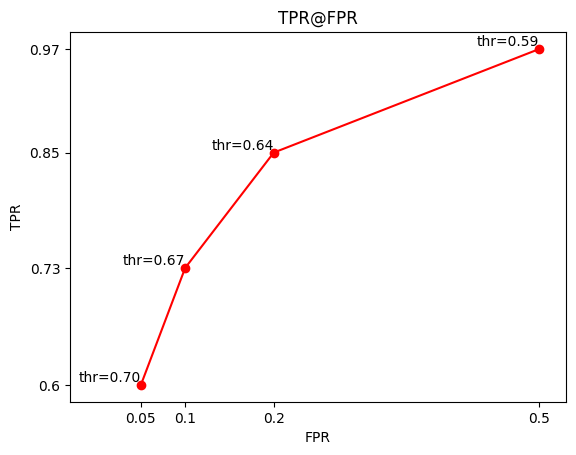

In [29]:
plt.plot(fpr, ir, linestyle='-', marker='o', color='r', label='Lines')
plt.xticks(fpr,fpr)
plt.yticks(ir, [round(i,2) for i in ir])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('TPR@FPR')

custom_xlim = -0.03
plt.xlim(custom_xlim, max(fpr) + 0.03)

for i, txt in enumerate(ir):
    plt.text(fpr[i], ir[i], f'thr={thresholds[i]:.2f}', ha='right', va='bottom');

Можем увидеть, что чем сильнее мы фиксируем вероятность ошибки сказать на одного человека разные id, тем ниже число верных ответов (что логично)

При жесткой фиксации ошибки наша модель выдает правильные ответы с вероятностью 0.6, а если разрешить модели ошибаться с вероятностью 0.5, то вероятность правильных ответов будет 0.97

### explore similarity

Выберем рандомную картинку и посмотрим на похожие и различные изображения на нее

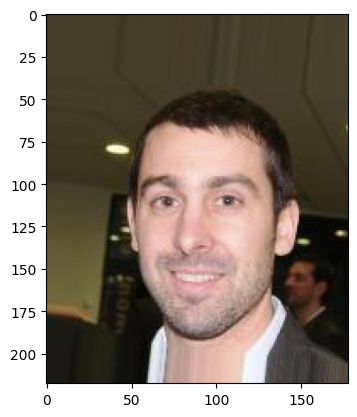

In [126]:
random.seed(seed)
test_img = random.choice(test_dataset.files)
img = skimage.io.imread(f"./data/celebA_train_500/celebA_imgs/{test_img}")
plt.imshow(img);

In [128]:
img_emb = compute_embeddings(model_without_last_layer, './data/celebA_train_500/celebA_imgs/', [test_img])
img_emb = img_emb[0]

In [129]:
# we not take all images, just for time saving
all_test_images_names = list(split[split['class'] == 2]['name_img'])
all_img_emb = compute_embeddings(model_without_last_layer, './data/celebA_train_500/celebA_imgs/', all_test_images_names)

In [130]:
cos_sim = []
for i in range(len(all_test_images_names)):
    if all_test_images_names[i] != test_img:
        idx1 = all_test_images_names.index(all_test_images_names[i])
        obj1 = all_img_emb[idx1]
        obj2 = img_emb
        cs = cosine_similarity(obj1, obj2)
        cos_sim.append(cs)

In [131]:
cos_sim = sorted([[i,j] for i,j in zip([i for i in all_test_images_names if i != test_img], cos_sim)], key=lambda x: -x[1])

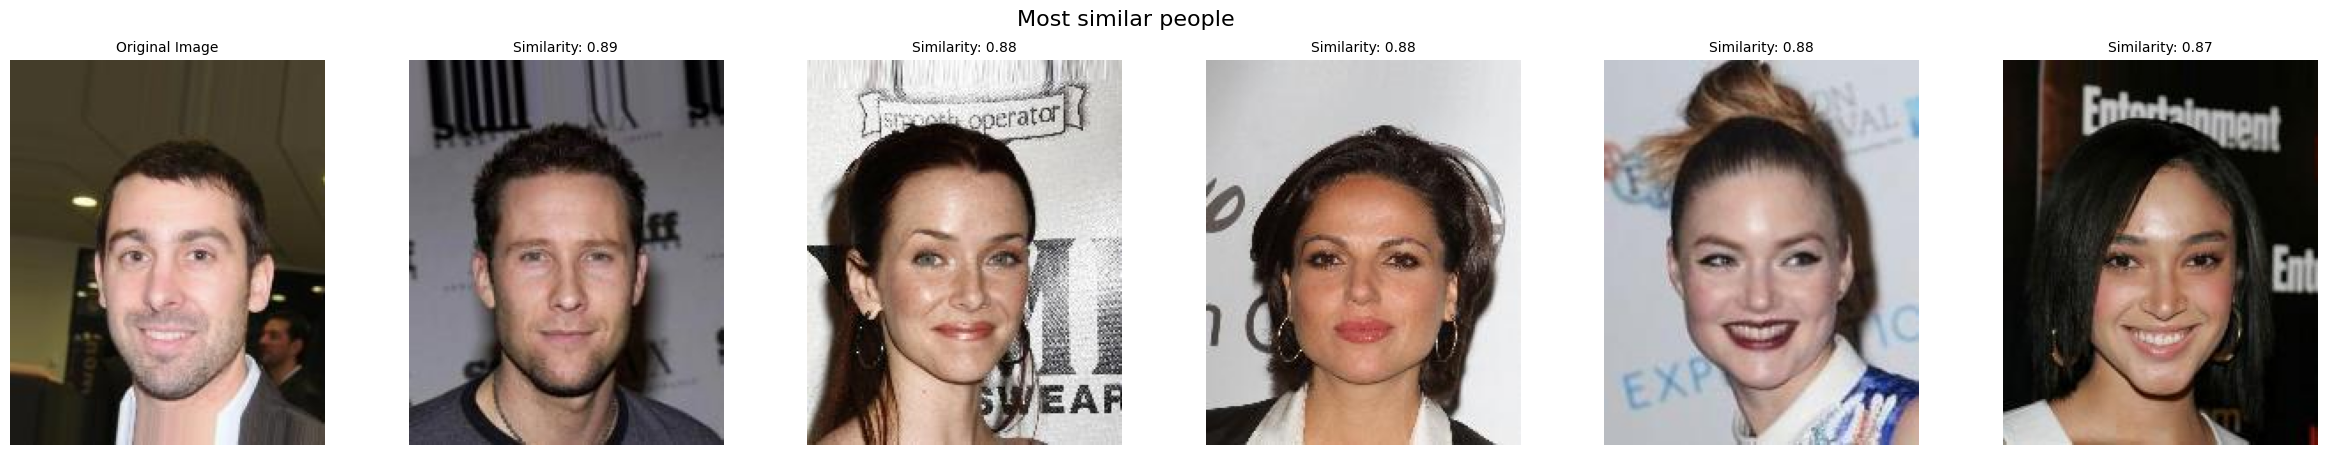

In [132]:
top5 = cos_sim[:5]
fig, axes = plt.subplots(1, len(top5) + 1, figsize=((len(top5) + 1) * 5, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=10)
axes[0].axis('off')

# Assuming top5 is a list of tuples containing (name_img, sim_img)
for ax, (name_img, sim_img) in zip(axes[1:], top5):
    img2 = skimage.io.imread(f"./data/celebA_train_500/celebA_imgs/{name_img}")
    ax.imshow(img2)
    ax.set_title(f"Similarity: {sim_img:.2f}", fontsize=10)
    ax.axis('off')

fig.suptitle("Most similar people", fontsize=16)
plt.show()

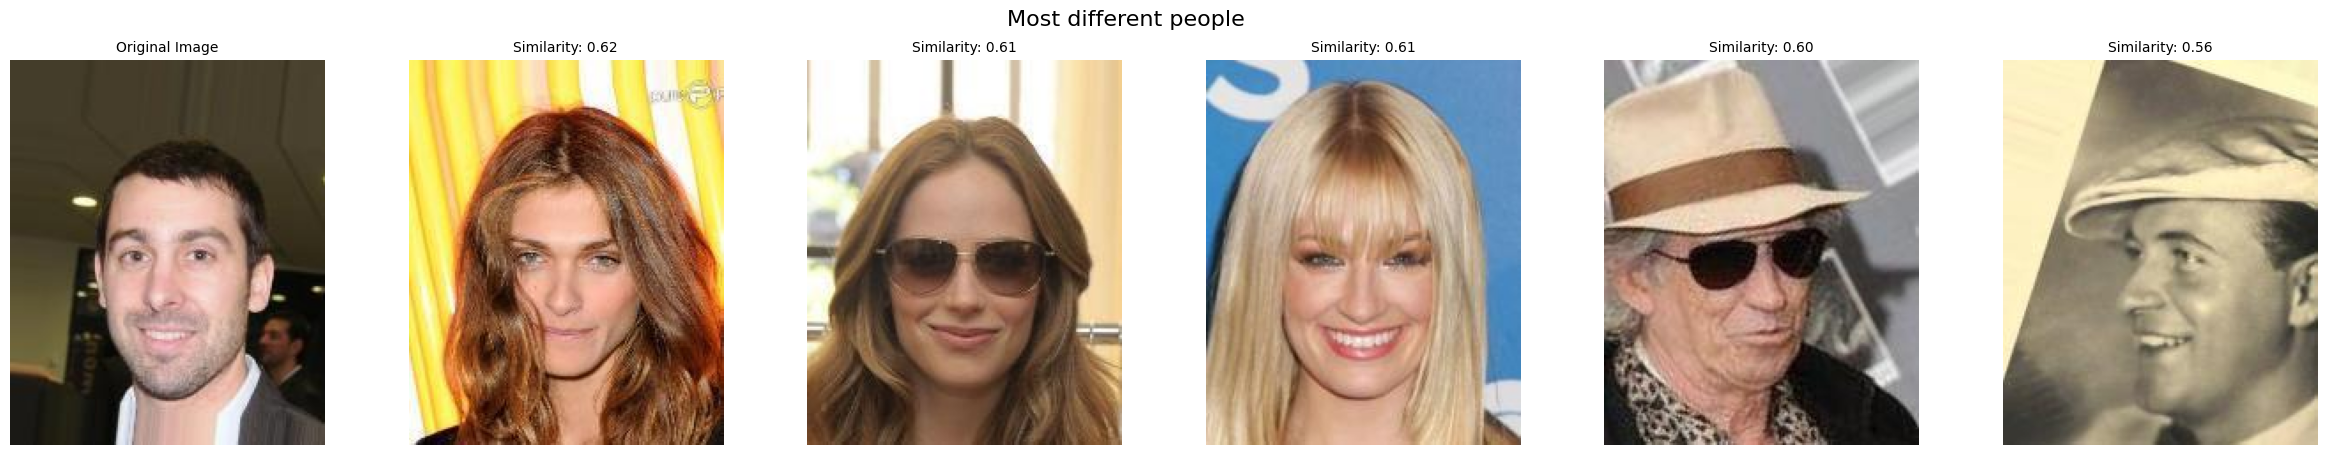

In [133]:
down5 = cos_sim[-5:]
fig, axes = plt.subplots(1, len(top5) + 1, figsize=((len(top5) + 1) * 5, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=10)
axes[0].axis('off')

# Assuming top5 is a list of tuples containing (name_img, sim_img)
for ax, (name_img, sim_img) in zip(axes[1:], down5):
    img2 = skimage.io.imread(f"./data/celebA_train_500/celebA_imgs/{name_img}")
    ax.imshow(img2)
    ax.set_title(f"Similarity: {sim_img:.2f}", fontsize=10)
    ax.axis('off')

fig.suptitle("Most different people", fontsize=16)
plt.show()

Видим, что первые картинки людей действительно больше похожи на нашу тестовую картинку, чем последние, Но много женских лиц

# model_Arc_Face

In [31]:
# Set the seed for PyTorch
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [32]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [34]:
class CustomResNet(nn.Module):
    def __init__(self, model, n_classes):
        super(CustomResNet, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-2])
        
        # Define the new fully connected layers
        self.fc = nn.Sequential(
                    nn.Linear(model.fc.in_features, n_classes),
        )


    def forward(self, x):
        features_before_fc = self.features(x)
        features_before_fc = torch.mean(features_before_fc, dim=[2, 3])
        features_before_fc = features_before_fc.view(features_before_fc.size(0), -1)

        final_output = self.fc(features_before_fc)

        return features_before_fc, final_output

In [37]:
model = torch.load('./models/model_af.bin', map_location=torch.device('cpu'))

In [38]:
model.eval()
test_correct = 0
test_total_samples = 0

with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_inputs = test_inputs.to(device)
        test_labels = test_labels.to(device)
        _, test_outputs = model(test_inputs)
        _, test_predicted = torch.max(test_outputs, 1)
        test_correct += (test_predicted == test_labels).sum().item()
        test_total_samples += test_labels.size(0)

test_accuracy = test_correct / test_total_samples
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.7319


# IR for Arc_face model

In [39]:
class ModelWithoutLastLayer(nn.Module):
    def __init__(self, model):
        super(ModelWithoutLastLayer, self).__init__()
        self.features = nn.Sequential(*list(model.children())[:-1])

    def forward(self, x):
        return self.features(x)
    
model_without_last_layer = ModelWithoutLastLayer(model)

In [40]:
query_embeddings = compute_embeddings(model_without_last_layer, './data/celebA_ir/celebA_query', query_img_names)
distractors_embeddings = compute_embeddings(model_without_last_layer, './data/celebA_ir/celebA_distractors', distractors_img_names)

In [41]:
cosine_query_pos = compute_cosine_query_pos(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_neg = compute_cosine_query_neg(query_dict, query_img_names,
                                            query_embeddings)
cosine_query_distractors = compute_cosine_query_distractors(query_embeddings,
                                                            distractors_embeddings)

In [42]:
fpr = [0.5, 0.2, 0.1, 0.05]
thresholds = []
ir = []
for f in fpr:
    thr, tpr = compute_ir(cosine_query_pos, cosine_query_neg, cosine_query_distractors, fpr=f)
    thresholds.append(thr)
    ir.append(tpr)

In [43]:
thresholds, ir

([0.21723738, 0.26778466, 0.30532137, 0.34536353],
 [0.8786087901637117,
  0.6765844711636437,
  0.5055363086746825,
  0.34474560152163575])

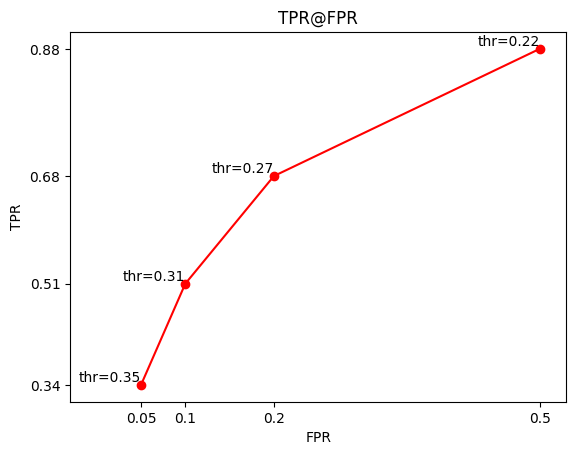

In [44]:
plt.plot(fpr, ir, linestyle='-', marker='o', color='r', label='Lines')
plt.xticks(fpr,fpr)
plt.yticks(ir, [round(i,2) for i in ir])
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('TPR@FPR')

custom_xlim = -0.03
plt.xlim(custom_xlim, max(fpr) + 0.03)

for i, txt in enumerate(ir):
    plt.text(fpr[i], ir[i], f'thr={thresholds[i]:.2f}', ha='right', va='bottom');

Пороги расстояний получились ниже, чем для первой модели. Также как и сама метрика правильных значений получилась ниже для каждого фиксированного FPR, но общий тренд похож.
Возможно для данного лосса модель сильнее штрафует непохожие картинки друг на друга, или лосс реализован неправильно (что более вероятно)

### explore similarity

Выберем рандомную картинку и посмотрим на похожие и различные изображения на нее

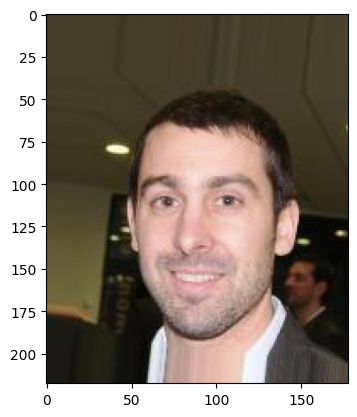

In [89]:
random.seed(seed)
test_img = random.choice(test_dataset.files)
img = skimage.io.imread(f"./data/celebA_train_500/celebA_imgs/{test_img}")
plt.imshow(img);

In [92]:
img_emb = compute_embeddings(model_without_last_layer, './data/celebA_train_500/celebA_imgs/', [test_img])
img_emb = img_emb[0]

In [93]:
# we not take all images, just for time saving
all_test_images_names = list(split[split['class'] == 2]['name_img'])
all_img_emb = compute_embeddings(model_without_last_layer, './data/celebA_train_500/celebA_imgs/', all_test_images_names)

In [100]:
cos_sim = []
for i in range(len(all_test_images_names)):
    if all_test_images_names[i] != test_img:
        idx1 = all_test_images_names.index(all_test_images_names[i])
        obj1 = all_img_emb[idx1]
        obj2 = img_emb
        cs = cosine_similarity(obj1, obj2)
        cos_sim.append(cs)

In [108]:
cos_sim = sorted([[i,j] for i,j in zip([i for i in all_test_images_names if i != test_img], cos_sim)], key=lambda x: -x[1])

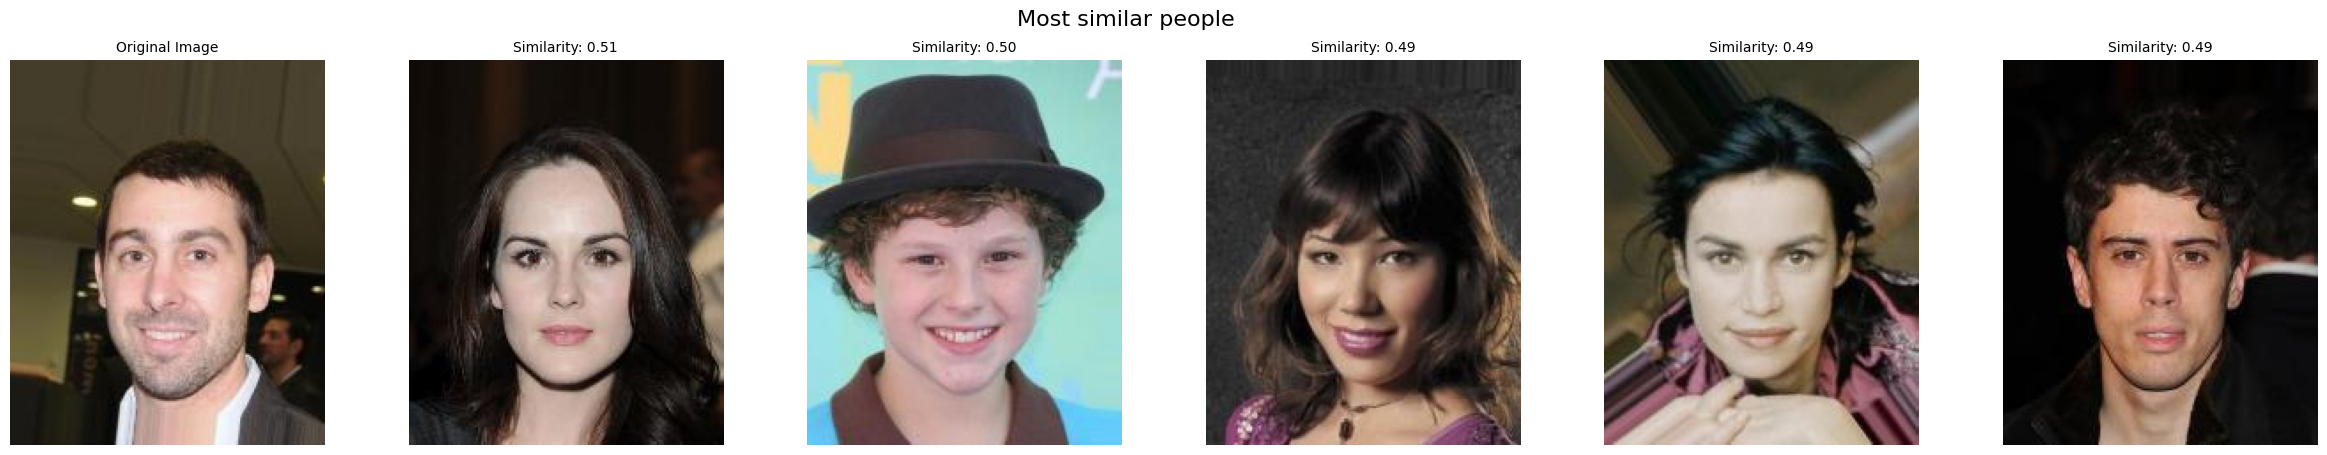

In [116]:
top5 = cos_sim[:5]
fig, axes = plt.subplots(1, len(top5) + 1, figsize=((len(top5) + 1) * 5, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=10)
axes[0].axis('off')

# Assuming top5 is a list of tuples containing (name_img, sim_img)
for ax, (name_img, sim_img) in zip(axes[1:], top5):
    img2 = skimage.io.imread(f"./data/celebA_train_500/celebA_imgs/{name_img}")
    ax.imshow(img2)
    ax.set_title(f"Similarity: {sim_img:.2f}", fontsize=10)
    ax.axis('off')

fig.suptitle("Most similar people", fontsize=16)
plt.show()

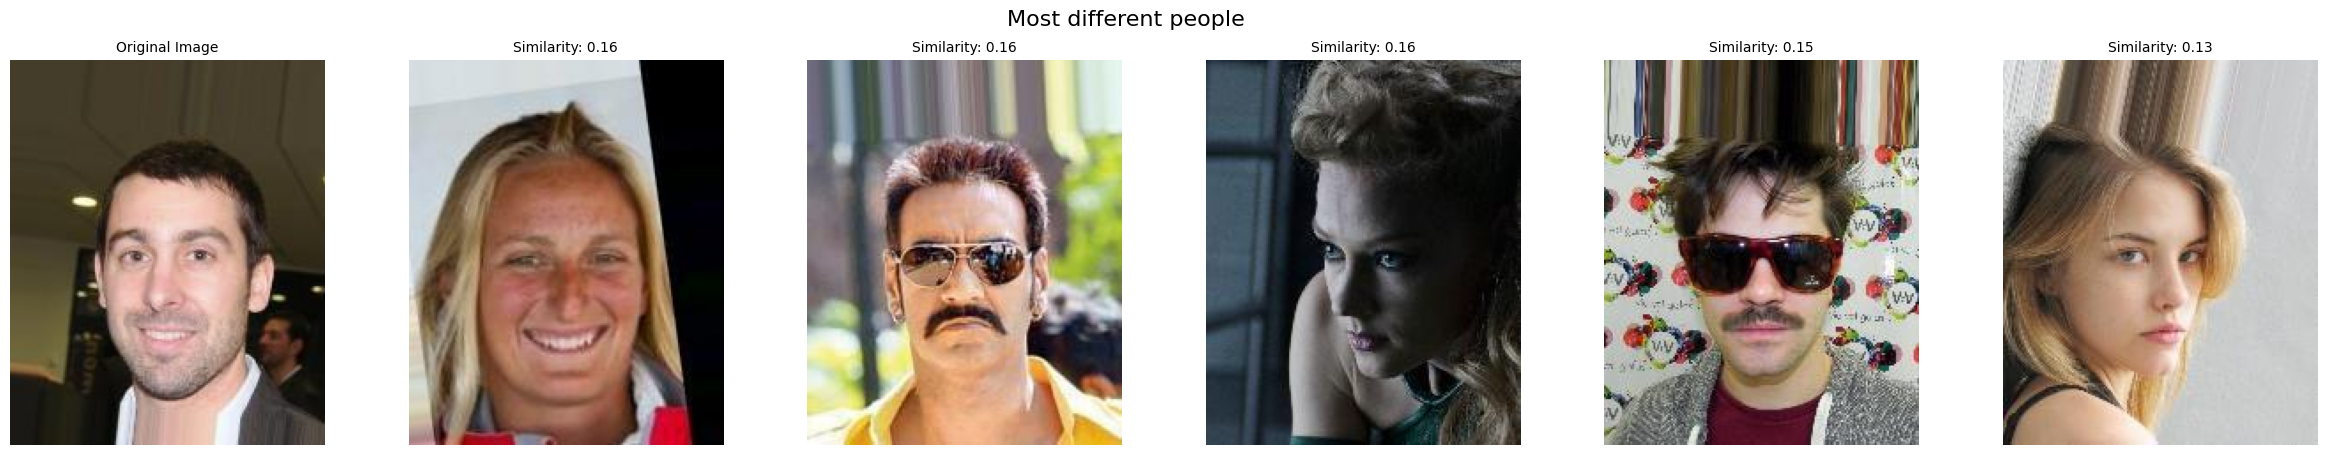

In [120]:
down5 = cos_sim[-5:]
fig, axes = plt.subplots(1, len(top5) + 1, figsize=((len(top5) + 1) * 5, 5))

axes[0].imshow(img)
axes[0].set_title("Original Image", fontsize=10)
axes[0].axis('off')

# Assuming top5 is a list of tuples containing (name_img, sim_img)
for ax, (name_img, sim_img) in zip(axes[1:], down5):
    img2 = skimage.io.imread(f"./data/celebA_train_500/celebA_imgs/{name_img}")
    ax.imshow(img2)
    ax.set_title(f"Similarity: {sim_img:.2f}", fontsize=10)
    ax.axis('off')

fig.suptitle("Most different people", fontsize=16)
plt.show()

Видим, что первые картинки людей действительно больше похожи на нашу тестовую картинку, чем последние. И в этой модели люди получились более похожи на оригинальное изображение